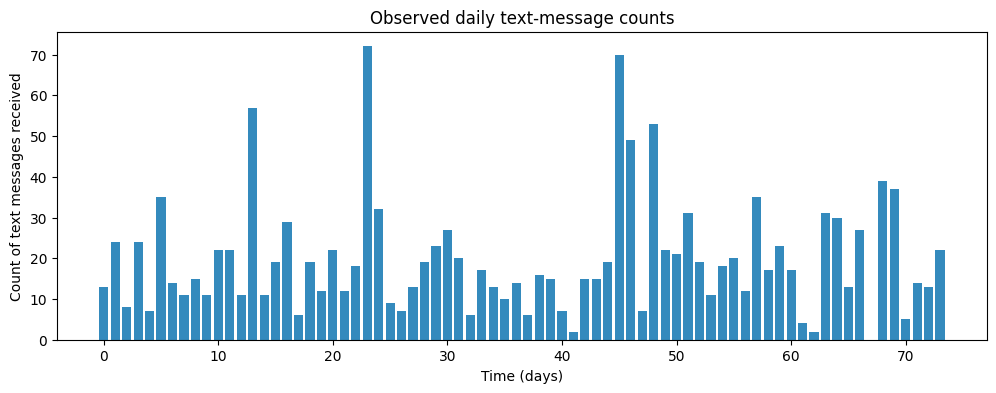

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 3 seconds.


<Figure size 1200x1000 with 0 Axes>

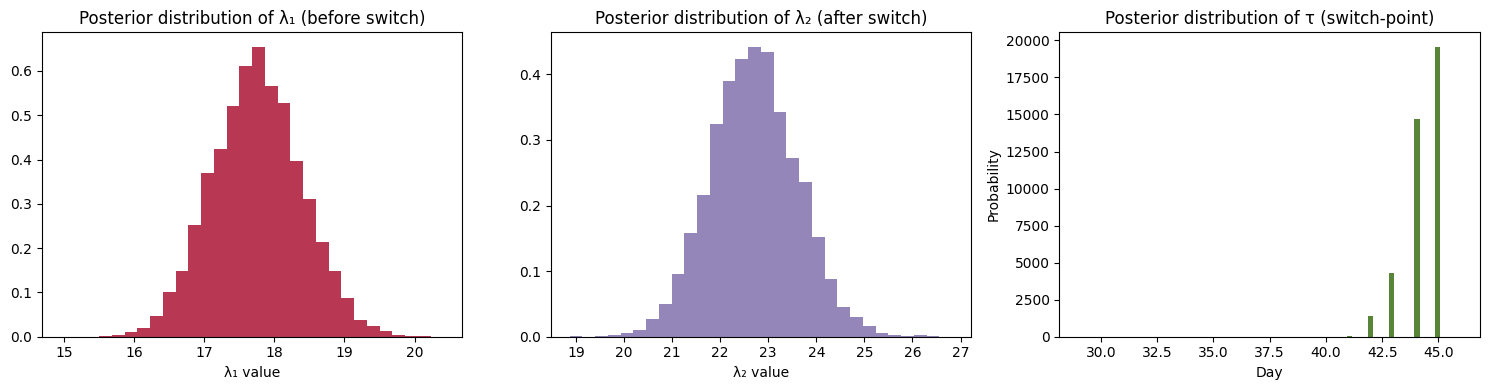

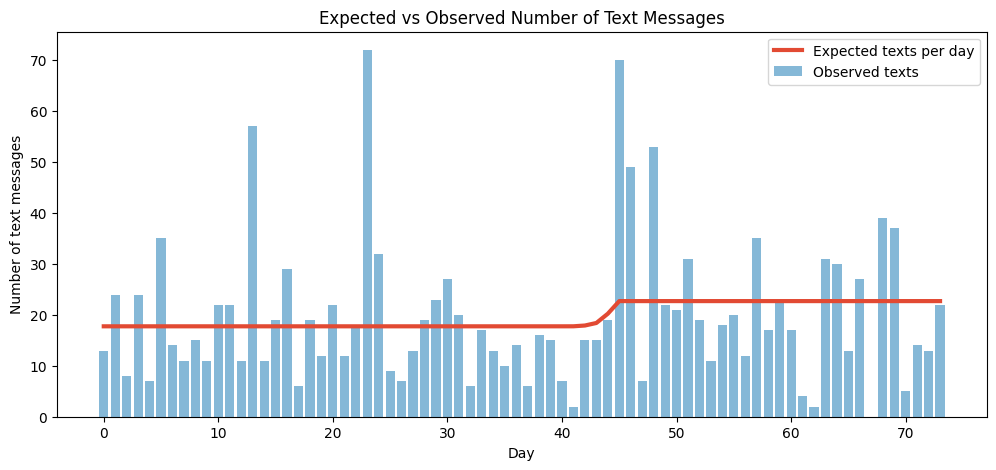

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

count_data = np.loadtxt("txtdata.csv")
n_count_data = len(count_data)

plt.figure(figsize=(12, 4))
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Count of text messages received")
plt.title("Observed daily text-message counts")
plt.show()

with pm.Model() as model:
    alpha = 1.0 / count_data.mean()

    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=count_data)

    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False, progressbar=True)


lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']


plt.figure(figsize=(12, 10))

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].hist(lambda_1_samples, bins=30, color="#A60628", density=True, alpha=0.8)
axs[0].set_title("Posterior distribution of λ₁ (before switch)")
axs[0].set_xlabel("λ₁ value")

axs[1].hist(lambda_2_samples, bins=30, color="#7A68A6", density=True, alpha=0.8)
axs[1].set_title("Posterior distribution of λ₂ (after switch)")
axs[1].set_xlabel("λ₂ value")

axs[2].hist(tau_samples, bins=n_count_data, color="#467821", alpha=0.9)
axs[2].set_title("Posterior distribution of τ (switch-point)")
axs[2].set_xlabel("Day")
axs[2].set_ylabel("Probability")


plt.tight_layout()
plt.show()

N = len(tau_samples)
expected_texts_per_day = np.zeros(n_count_data)

for day in range(n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (
        lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()
    ) / N


plt.figure(figsize=(12, 5))
plt.plot(expected_texts_per_day, lw=3, color="#E24A33", label="Expected texts per day")
plt.bar(np.arange(n_count_data), count_data, color="#348ABD", alpha=0.6, label="Observed texts")
plt.xlabel("Day")
plt.ylabel("Number of text messages")
plt.title("Expected vs Observed Number of Text Messages")
plt.legend()
plt.show()
